In [263]:
import fiona
import numpy as np
from pathlib import Path
import os

import rasterio as rio
from rasterio import windows
from rasterio import features
import rasterio.plot as rioplot
from rasterio.warp import transform_bounds

from itertools import product
from rtree import index

from shapely.geometry import mapping, LineString, shape
import geopandas as gp
import json
%matplotlib inline 

In [264]:
DST_CRS = 'EPSG:4326'

RAW_IMAGES = '../data/raw/images'
RAW_LABELS = '../data/raw/labels'

TRAINING_DIR = '../data/train'
TRAINING_SAT_DIR = '{}/sat'.format(TRAINING_DIR)
TRAINING_MAP_DIR = '{}/map'.format(TRAINING_DIR)

In [265]:
window_size = 1500
output_tile_filename = '{}/tile_{}-{}.tif'
output_map_filename = '{}/tile_{}-{}.tif'

In [266]:
Path(RAW_IMAGES).mkdir(exist_ok=True)
Path(RAW_LABELS).mkdir(exist_ok=True)

Path(TRAINING_DIR).mkdir(exist_ok=True)
Path(TRAINING_SAT_DIR).mkdir(exist_ok=True)
Path(TRAINING_MAP_DIR).mkdir(exist_ok=True)

In [267]:
def create_spatial_index():
    idx = index.Index()
    with fiona.open("{}/walker_3093.geojson".format(RAW_LABELS), "r") as geojson:
        lines = [LineString(feature["geometry"]["coordinates"]) for feature in geojson]
#         json.dumps(mapping(lines))
#         plot_shapes(lines)
        count = -1
        for line in lines:
            count +=1
            idx.insert(count, line.bounds, obj=line)
    return idx    


In [268]:
def transform_bnds(src_crs, dst_crs,src_bounds):
    return transform_bounds(src_crs,dst_crs,src_bounds[0], src_bounds[1], src_bounds[2], src_bounds[3] )

In [269]:
def plot_shapes(geom):
    df  = gp.GeoDataFrame(geometry=geom, crs={'init': 'epsg:32750'})
    df.plot()


In [270]:
def write_map(src, window, meta):
#     print(src.window_bounds(window))
    outpath = output_map_filename.format(TRAINING_MAP_DIR,int(window.col_off),int(window.row_off))

    dst_bounds = transform_bnds(src.crs, DST_CRS, src.window_bounds(window))
    print(dst_bounds)
    intersecting_road_items = idx.intersection(dst_bounds,objects=True)
    roads = list(intersecting_road_items)
    lines = [r.object for r in roads]
    
    with rio.open(outpath, 'w', **meta) as outds:
#         out_arr = outds.read(1)
        if len(lines) > 0:
            print("match found")
            plot_shapes(lines)
            plot_shapes(lines)
#             fig.save("foo.png")
            burned = features.rasterize(shapes=lines, fill=1,out_shape=(window_size,window_size), all_touched=True, transform=src.transform)
            rioplot.show(burned)
            outds.write(burned, indexes=1)

In [271]:
def write_tile(src, window, meta):
    outpath = output_tile_filename.format(TRAINING_SAT_DIR,int(window.col_off),int(window.row_off))
    with rio.open(outpath, 'w', **meta) as outds:
        outds.write(src.read(window=window))

In [272]:
def make_tiles(file):
    with rio.open(file, crs=DST_CRS) as inds:
          tile_width, tile_height = window_size, window_size
          meta = inds.meta.copy()
          for window, transform in get_tiles(inds):
            meta['transform'] = transform
            meta['width'], meta['height'] = window.width, window.height
            write_tile(inds, window, meta)
            write_map(inds, window, meta)

In [273]:
def get_tiles(ds, width=window_size, height=window_size):
    nols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, nols, width), range(0, nrows, height))
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in  offsets:
        window =windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform

(116.18510030732838, -1.2666049090506963, 116.22555846193652, -1.2258838547392588)
(116.18508738633402, -1.3073138702316769, 116.22554657083862, -1.2665924275963238)
(116.18507491263865, -1.3454445850872718, 116.22553429099716, -1.3073009874890158)
match found


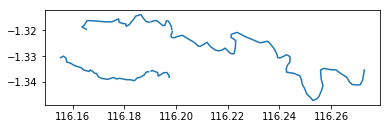

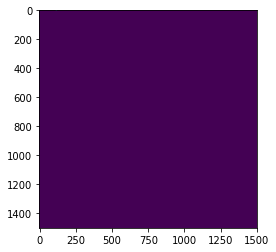

(116.22554657083862, -1.2666167553902066, 116.26600449330455, -1.2258959349173175)
(116.22553429099716, -1.307326097440051, 116.26599322309222, -1.2666049090506963)
match found


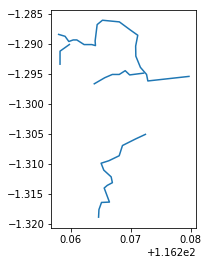

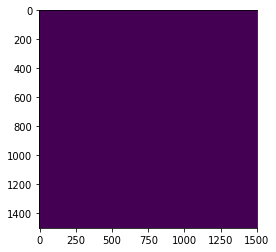

(116.22552243625925, -1.3454571690534483, 116.2659815844343, -1.3073138702316769)
match found


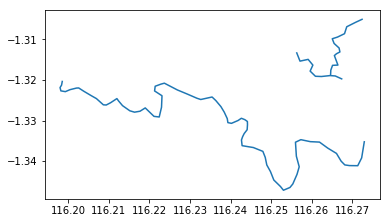

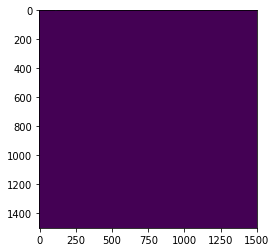

(116.26599322309222, -1.2666279665853053, 116.30645089308987, -1.2259074003993287)
(116.2659815844343, -1.3073376690836382, 116.30644024379123, -1.2666167553902066)
match found


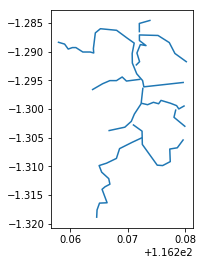

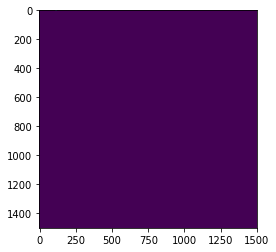

(116.26597034868342, -1.3454690783271839, 116.30642924634591, -1.307326097440051)
match found


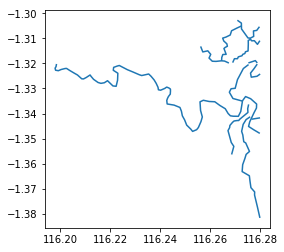

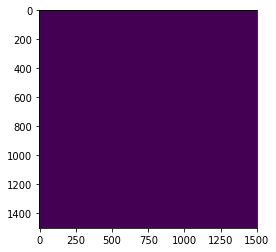

(116.30644024379123, -1.2666385426080273, 116.34689764099515, -1.2259182511566944)
(116.30642924634591, -1.3073485851335749, 116.34688761263675, -1.2666279665853053)
(116.30641862961014, -1.3454803128787713, 116.34687725643145, -1.3073376690836382)
(116.34688761263675, -1.2666484834319909, 116.38734471672218, -1.2259284871623481)
(116.34687725643145, -1.3073588455626302, 116.38733530932907, -1.2666385426080273)
(116.34686725873728, -1.3454908726801862, 116.38732559438964, -1.3073485851335749)
(116.38733530932907, -1.2666577890323993, 116.42779209997194, -1.2259381083907586)
(116.38732559438964, -1.3073684503452097, 116.4277833135676, -1.2666484834319909)
(116.38731621576197, -1.3455007577050853, 116.42777423991825, -1.3073588455626302)
(116.4277833135676, -1.266657950713143, 116.42852015556285, -1.2259471148179244)
(116.42777423991825, -1.307368617224113, 116.4285113803365, -1.2666577890323993)
(116.4277654803805, -1.3455009294530764, 116.42850231823061, -1.3073684503452097)


In [274]:
n = 0
idx=create_spatial_index()
for file in Path(RAW_IMAGES).iterdir():
    if file.name.endswith(('.tif', '.tiff')):
        make_tiles(file)
        n=n+1
        if n >= 1:
            break